In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import numpy as np
from sklearn.linear_model import Lasso

In [2]:
train_data = pd.read_csv("train_data.csv")

Посмотрим на данные в датасете. Выведем 5 первых наблюдений

In [3]:
train_data.head()

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


Посмотрим, какие значения принимают каждые параметры, среднее, среднее отклонение, минимальное и максимальное значения


In [4]:
train_data.describe()

,row_ID,current_mileage,vehicle_year,car_leather_interior,final_price
count,35000.000000,3.500000e+04,35000.000000,35000.000000,3.500000e+04
mean,17499.500000,1.969224e+06,2010.651743,0.715486,6.014077e+03
std,10103.774047,5.682401e+07,12.247792,0.451189,7.341517e+04
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,8749.750000,7.145400e+04,2008.000000,0.000000,1.350000e+03
50%,17499.500000,1.290000e+05,2012.000000,1.000000,3.900000e+03
75%,26249.250000,1.900000e+05,2014.000000,1.000000,7.000000e+03
max,34999.000000,2.147484e+09,2020.000000,1.000000,8.388607e+06


In [5]:
train_data.columns

Index(['row_ID', 'vehicle_manufacturer', 'vehicle_model', 'vehicle_category',
       'current_mileage', 'vehicle_year', 'vehicle_gearbox_type', 'doors_cnt',
       'wheels', 'vehicle_color', 'vehicle_interior_color', 'car_vin',
       'car_leather_interior', 'deal_type', 'final_price'],
      dtype='object')

In [6]:
train_data.dtypes

row_ID                      int64
vehicle_manufacturer       object
vehicle_model              object
vehicle_category           object
current_mileage             int64
vehicle_year                int64
vehicle_gearbox_type       object
doors_cnt                  object
wheels                     object
vehicle_color              object
vehicle_interior_color     object
car_vin                    object
car_leather_interior        int64
deal_type                  object
final_price               float64
dtype: object

Посмотрим, какие типы принимают признаки. Заметим, что doors_cnt -- это строка, поэтому к нему придётся использовать one-hot кодирование, либо переводить его в float. Попробуем применить оба подхода и сравним результат

In [7]:
train_data['deal_type'].value_counts()

For Sale    34372
For Rent      628
Name: deal_type, dtype: int64

In [8]:
train_data = train_data.query("deal_type == 'For Sale'")

In [9]:
train_data['deal_type'].value_counts()

For Sale    34372
Name: deal_type, dtype: int64

Посмотрели, какие значения принимает признак "deal_type". В датасете есть 628 автомобилей, сдающихся в аренду, их нужно выбросить, если в качестве целевой переменной брать стоимость продажи


In [10]:
train_data['current_mileage'].describe()

count    3.437200e+04
mean     1.907385e+06
std      5.584060e+07
min      0.000000e+00
25%      7.149500e+04
50%      1.290000e+05
75%      1.905522e+05
max      2.147484e+09
Name: current_mileage, dtype: float64

Посмотрим на значения пробега: видно, что среднее $1.9 \cdot 10^6$, а максимальное значение $2.14 \cdot 10^9$, скорее всего, есть выбросы по этому признаку, с ними нужно будет что-то сделать

In [11]:
train_data[train_data['current_mileage'] >= 10**6].count()

row_ID                    157
vehicle_manufacturer      157
vehicle_model             157
vehicle_category          157
current_mileage           157
vehicle_year              157
vehicle_gearbox_type      157
doors_cnt                 157
wheels                    157
vehicle_color             157
vehicle_interior_color    157
car_vin                    19
car_leather_interior      157
deal_type                 157
final_price               157
dtype: int64

Заметим, что всего у 74 автомобилей значение 'current_mileage' $\geq 10^7$, поэтому можно попробовать выбросить все эти значения 

In [12]:
train_data = train_data.query("current_mileage <= 1000000")

In [13]:
train_data['current_mileage'].describe()

count      34217.000000
mean      141280.750592
std       101848.017373
min            0.000000
25%        71172.000000
50%       128202.000000
75%       190000.000000
max      1000000.000000
Name: current_mileage, dtype: float64

In [14]:
train_data['vehicle_year'].describe()

count    34217.000000
mean      2010.750709
std         12.313542
min          0.000000
25%       2009.000000
50%       2012.000000
75%       2014.000000
max       2020.000000
Name: vehicle_year, dtype: float64

In [15]:
train_data[train_data['vehicle_year'] <= 1920].count()

row_ID                    1
vehicle_manufacturer      0
vehicle_model             0
vehicle_category          0
current_mileage           1
vehicle_year              1
vehicle_gearbox_type      0
doors_cnt                 0
wheels                    0
vehicle_color             0
vehicle_interior_color    0
car_vin                   0
car_leather_interior      1
deal_type                 1
final_price               1
dtype: int64

Также есть выброс в 'vehicle_year'. Какой-то из автомобилей был сделан в 0 году, а такого значения быть не может. Его тоже нужно проигнорировать

In [16]:
train_data = train_data.query("vehicle_year >= 1920")

In [17]:
train_data['vehicle_year'].describe()

count    34216.000000
mean      2010.809475
std          5.784141
min       1940.000000
25%       2009.000000
50%       2012.000000
75%       2014.000000
max       2020.000000
Name: vehicle_year, dtype: float64

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

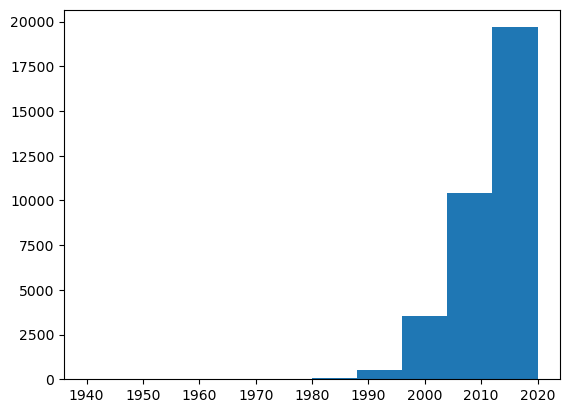

In [19]:
plt.hist(train_data['vehicle_year'])
plt.show()

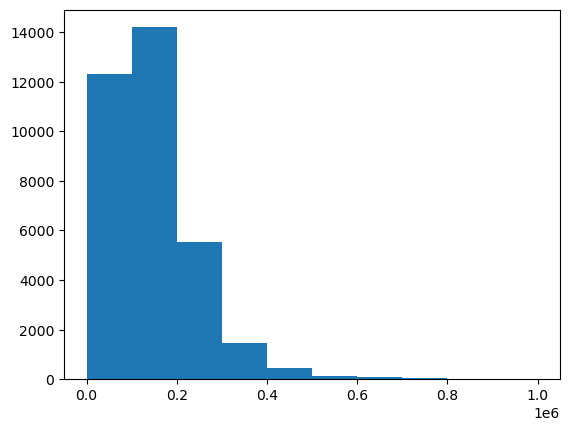

In [20]:
plt.hist(train_data['current_mileage'])
plt.show()

Для того, чтобы избавиться от переобучения, выбросим из датасета столбцы row_ID и car_vin

In [21]:
columns_to_drop = ['row_ID', 'car_vin']

train_data = train_data.drop(columns = columns_to_drop)

In [22]:
train_data.head()

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,0,For Sale,3650.0
1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,0,For Sale,6800.0
2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,1,For Sale,6300.0
3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,1,For Sale,14488.0
4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,1,For Sale,5000.0


In [47]:
train_data = train_data.dropna()

y = train_data['final_price']
X = train_data.drop(columns = ['final_price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.65, random_state = 42)


In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [64]:
numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns

categorical_data = X_train.select_dtypes([object])
categorical_features = categorical_data.columns

Index(['vehicle_manufacturer', 'vehicle_model', 'vehicle_category',
       'vehicle_gearbox_type', 'doors_cnt', 'wheels', 'vehicle_color',
       'vehicle_interior_color', 'deal_type'],
      dtype='object')


In [50]:
column_transform = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown = "ignore"), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('ohe and scaling', column_transform),
    ('Lasso regression', Lasso())
])

In [51]:
model = pipeline.fit(X_train, y_train)

In [55]:
y_pred = model.predict(X_test)

In [61]:
from sklearn.metrics import mean_absolute_error

MAE_loss = mean_absolute_error(y_test, y_pred)

print(MAE_loss)

5943.64920310952


Lasso регуляризация занулила весов:

In [70]:
len(model.named_steps['Lasso regression'].coef_) - np.count_nonzero(model.named_steps['Lasso regression'].coef_)

1347